# TRIP analysis of *E. coli* data
Here we show how to derive the TRIPs, as in Figure 5 of the paper. To do this, we get cell angle-binned expression, mean-adjust it, and then rotate it so that a cell angle of zero is equivalent to a gene's predicted replication time.

In [1]:
# Load in libraries
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scvi

print(sc.__version__)
print(scvi.__version__)

# Set figure parameters
#sns.set(font="Arial")
plt.style.use('default')
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

1.7.1
0.9.0


### 1. Importing and pre-processing

Import the data. We use the same processed data files as those used for the paper:

In [2]:
# Import angle information and correct using the zero angle procedure (see paper)
cell_angles = pd.read_table('samples/lb_cell_angles.txt',
                           index_col=0)['cell_angle']

zero_angle = 62.9596

cell_angles = (cell_angles - zero_angle) % 360

# Import scVI model and get normalized expression
adata = sc.read_h5ad('outputs/lb_adata.h5ad')
adata = adata[cell_angles.index,:]
model = scvi.model.SCVI.load('samples/D1_scVI_model',
                            adata)
scvi.settings.seed = 123
expression = model.get_normalized_expression()

Trying to set attribute `.uns` of view, copying.


INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category         
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 57627 cells, 3070 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Bin expression by cell angle:

In [3]:
binned_expression = expression.assign(bin=np.array(pd.cut(cell_angles, 100).apply(lambda x: x.mid))).\
                                      groupby('bin').mean()

Center expression by dividing by the mean. Note that we do not log-transform or scale the data here. This is to preserve features of the original dynamics, such as amplitude.

In [4]:
centered_expression = binned_expression.apply(lambda x: x / np.mean(x), 0)

Get the reproducible genes. To derive this list, we look at the correlation between two replicates (LB-grown WT *E. coli* from datasets D1 and D2) in expression treated as follows:

- scVI-smoothing and normalization
- Log-transformation and scaling
- Binning in 100 bins by cell angle and adjusting cell angle using the zeroing procedure (to allow comparison between datasets)

Genes with a Spearman correlation >0.7 between these datasets are considered reproducible.

In [5]:
reproducible = [line.rstrip() for line in open('reference/reproducible_genes.txt').readlines()]
len(reproducible)

936

### 2. Determining the predicted minimum for genes and zeroing expression based on replication timing
We interpret the predicted minimum as the approximate replication timing. This is because for genes whose expression pattern is dominated by copy number effect, the point at which expression will start to increase is expected to be the point of that gene's duplication. First, we import the predicted expression based on chromosomal position. This is an output of the "cycle_analysis.ipnb" workflow.

In [6]:
predicted_expression = pd.read_table('samples/lb_binned_expression_predicted.txt', index_col=0)

# Adjust the index using the zeroing procedure
predicted_expression.index = (predicted_expression.index - zero_angle) % 360
predicted_expression.sort_index(inplace=True)

Now determine the cell angle bin where predicted expression is at its minimum:

In [7]:
minima = predicted_expression.apply(lambda x: predicted_expression.index[
    np.where(x == np.min(x))[0][0]
], 0)

We next define a function to "rotate" expression so that this minimum point becomes the zero angle:

In [8]:
def rotate_genes(g):
    # Define the zero angle for an individual gene based on its predicted minimum
    zero_angle = minima[g]
    # Get the mean-centered gene expression
    expression = centered_expression[g].copy()
    # Recenter the cell angle bins according to the gene-specific zero angle, then sort expression based
    # on these new angles. Return this reordered expression vector.
    expression.index = (centered_expression.index - zero_angle) % 360
    return np.array(expression.sort_index())

rotated_expression = pd.DataFrame({
    g: rotate_genes(g) for g in centered_expression.columns
}, index=centered_expression.index)

This gives us our TRIPs. We can plot these to determine how well we've aligned the expression by this procedure. First of all, let's see what happens without alignment:

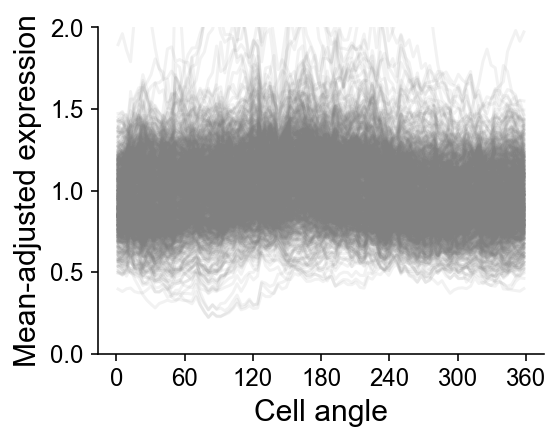

In [9]:
plt.figure(figsize=(4,3))

for g in reproducible: # Focus on reproducible genes - plot each one as a separate line
    plt.plot(centered_expression.index, centered_expression[g], alpha=0.1, color='grey')
plt.ylim(0, 2)
plt.ylabel('Mean-adjusted expression', size=15)
plt.xlabel('Cell angle', size=15)
plt.xticks([0, 60, 120, 180, 240, 300, 360])
plt.show()

There's clearly not much of a pattern here. What about when we do our alignment procedure?

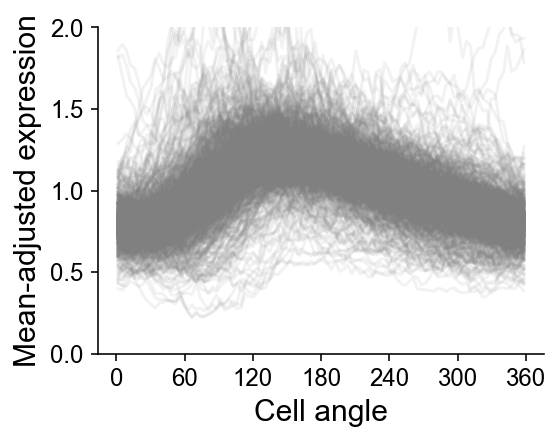

In [10]:
plt.figure(figsize=(4,3))

for g in reproducible: # Focus on reproducible genes - plot each one as a separate line
    plt.plot(rotated_expression.index, rotated_expression[g], alpha=0.1, color='grey')
plt.ylim(0, 2)
plt.ylabel('Mean-adjusted expression', size=15)
plt.xlabel('Cell angle', size=15)
plt.xticks([0, 60, 120, 180, 240, 300, 360])
plt.show()

Now we see a clear pattern emerge. These traces represent expression dynamics proceeding after replication, something we term a Transcription-Replication Interaction Profile (TRIP).

### 3. Defining TRIP clusters
Now we have the TRIPs defined, we can cluster them and look for particular patterns:

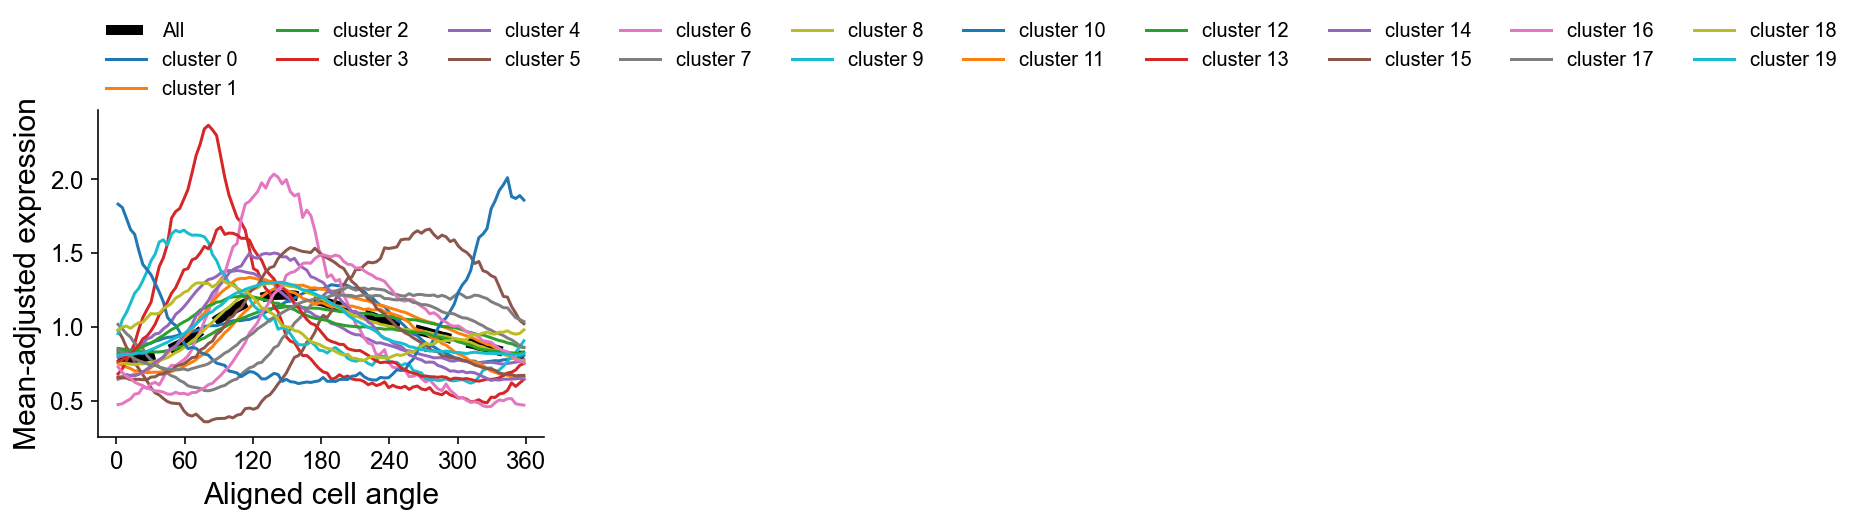

In [11]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=20, random_state=123).fit_predict(rotated_expression[reproducible].transpose())

cluster_ids = np.unique(clusters)

plt.figure(figsize=(4,3))

plt.plot(rotated_expression.index, rotated_expression[reproducible].mean(axis=1),
             label='All ', color='black', linestyle='dashed', linewidth=5)

for i in cluster_ids:
    plt.plot(rotated_expression.index, rotated_expression[reproducible].loc[:,clusters==i].mean(axis=1),
             label='cluster ' + str(i))
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=10,
            borderaxespad=0, frameon=False)
plt.xlabel('Aligned cell angle', size=15)
plt.ylabel('Mean-adjusted expression', size=15)
plt.xticks([0, 60, 120, 180, 240, 300, 360])
plt.show()

Note that the cluster numberings are slightly different from those used in the paper. This is an effect of differences in the random seed for the scVI `get_normalized_expression` function and the original clusters are provided as supplementary data accompanying the paper. 

We can examine individual clusters for equivalence, however, by importing information from the GFF:

In [16]:
gff = pd.read_csv("reference/GCF_000005845.2_ASM584v2_genomic.gff.gz",
                 sep="\t", comment='#', names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])

gff['name'] = gff['attribute'].str.replace("^.*;Name=", "", regex=True).str.replace(";.*$", "", regex=True)
gff['locus_tag'] = gff['attribute'].str.replace("^.*;locus_tag=", "", regex=True).str.replace(";.*$", "", regex=True)
gff.index = gff['locus_tag']
gff = gff.loc[gff['feature'] == 'gene']
gff = gff[['chrom', 'start', 'end', 'strand', 'name', 'locus_tag']]

Cluster 3 is identical to the (Class 2a) cluster Ec17:

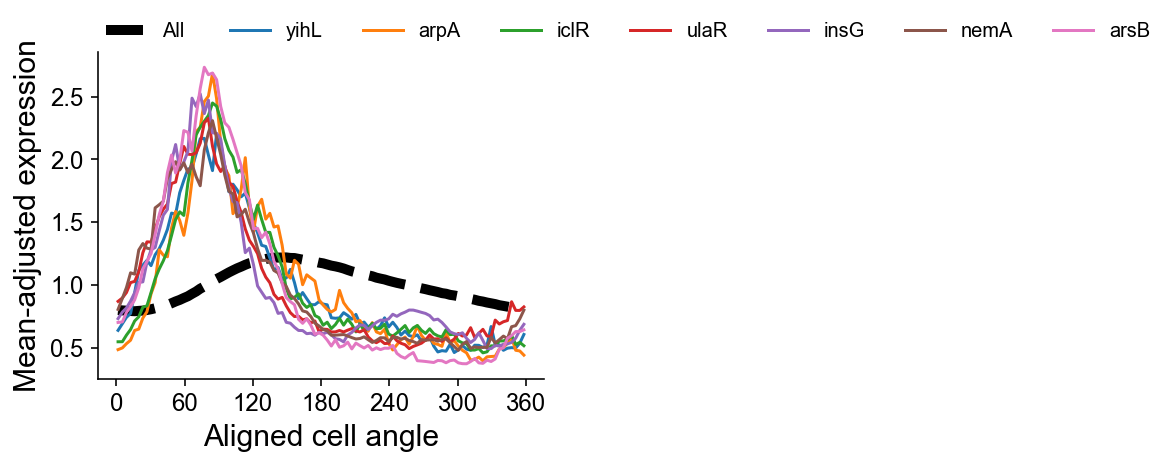

In [25]:
cluster_genes = np.array(reproducible)[clusters == 3]

plt.figure(figsize=(4,3))

plt.plot(rotated_expression.index, rotated_expression[reproducible].mean(axis=1),
             label='All ', color='black', linestyle='dashed', linewidth=5)

for g in cluster_genes:
    plt.plot(rotated_expression.index, rotated_expression[g],
             label=gff.loc[g, 'name'])
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=10,
            borderaxespad=0, frameon=False)
plt.xlabel('Aligned cell angle', size=15)
plt.ylabel('Mean-adjusted expression', size=15)
plt.xticks([0, 60, 120, 180, 240, 300, 360])
plt.show()

Cluster 6 differs from Ec9 (Class 2b) only by the omission of *aceB*:

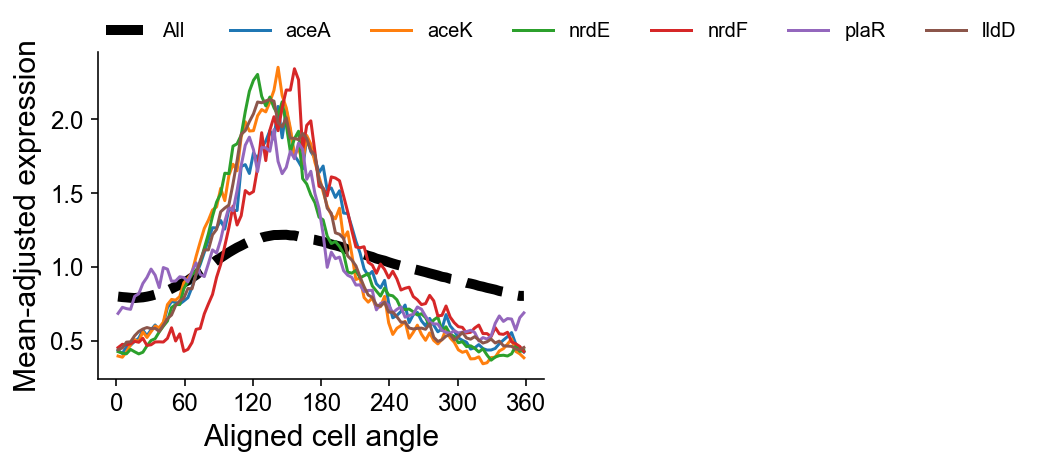

In [26]:
cluster_genes = np.array(reproducible)[clusters == 6]

plt.figure(figsize=(4,3))

plt.plot(rotated_expression.index, rotated_expression[reproducible].mean(axis=1),
             label='All ', color='black', linestyle='dashed', linewidth=5)

for g in cluster_genes:
    plt.plot(rotated_expression.index, rotated_expression[g],
             label=gff.loc[g, 'name'])
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=10,
            borderaxespad=0, frameon=False)
plt.xlabel('Aligned cell angle', size=15)
plt.ylabel('Mean-adjusted expression', size=15)
plt.xticks([0, 60, 120, 180, 240, 300, 360])
plt.show()


Cluster 5 is the delayed cluster, equivalent to Ec5 and containing genes exhibiting replication-associated repression:

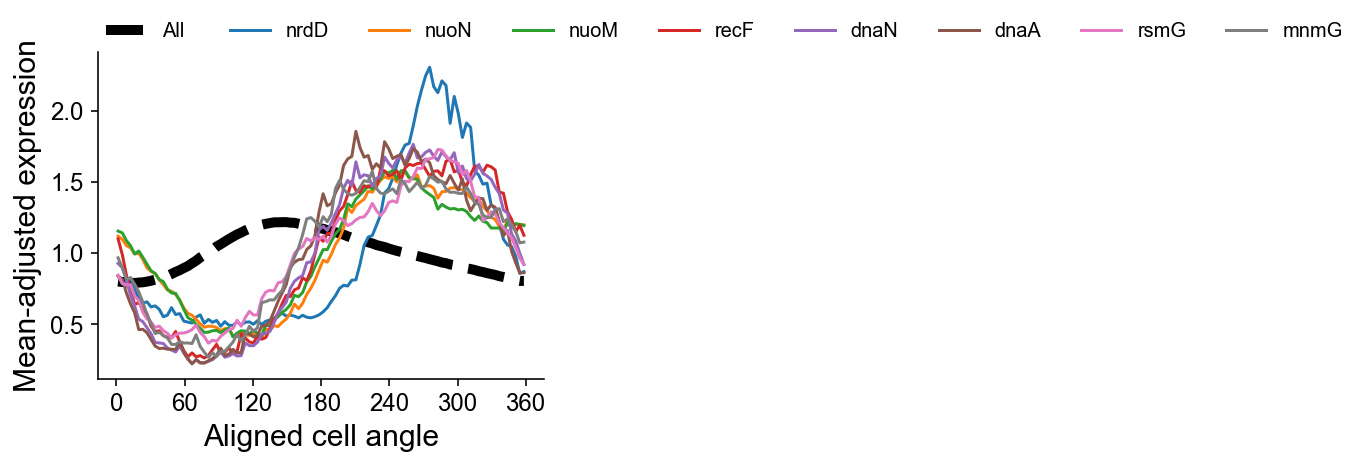

In [27]:
cluster_genes = np.array(reproducible)[clusters == 5]

plt.figure(figsize=(4,3))

plt.plot(rotated_expression.index, rotated_expression[reproducible].mean(axis=1),
             label='All ', color='black', linestyle='dashed', linewidth=5)

for g in cluster_genes:
    plt.plot(rotated_expression.index, rotated_expression[g],
             label=gff.loc[g, 'name'])
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=10,
            borderaxespad=0, frameon=False)
plt.xlabel('Aligned cell angle', size=15)
plt.ylabel('Mean-adjusted expression', size=15)
plt.xticks([0, 60, 120, 180, 240, 300, 360])
plt.show()
